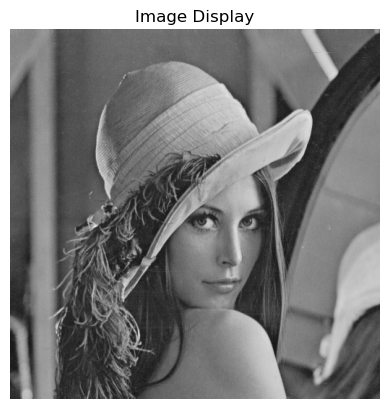

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_path = "./image/lena_grey.bmp"
img = cv2.imread(image_path, 0)

# Ensure the image was loaded successfully
if img is not None:
    # Convert image from BGR (OpenCV format) to RGB (Matplo`tlib format)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.title('Image Display')
    plt.axis('off')  # Hide axis
    plt.show()
else:
    print("Error: Could not load the image.")


<BarContainer object of 256 artists>

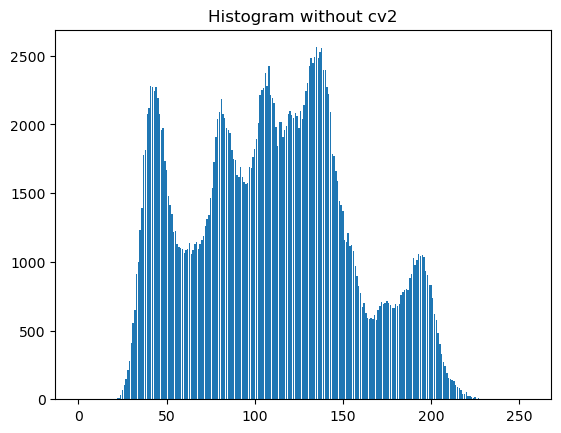

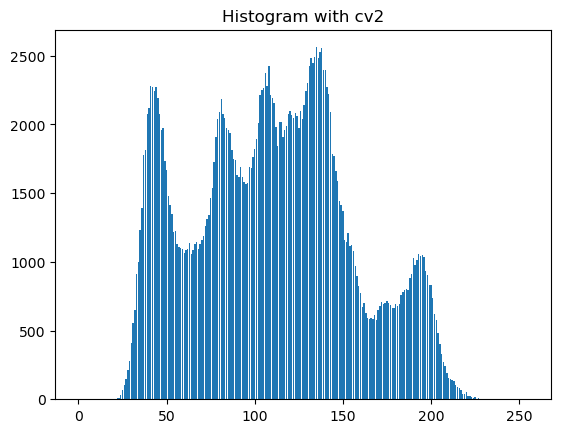

In [2]:
# Draw Histogram without cv2
h, w = img.shape[:2]
histogram = np.zeros(256)

for j in range(h):
    for i in range(w):
        histogram[img[j,i]] += 1

x = np.arange(256)

plt.figure(1)
plt.title("Histogram without cv2")
plt.bar(x, histogram)

# Draw Histogram with cv2

histogram = cv2.calcHist([img], [0], None, [256], [0,256])

plt.figure(2)
plt.title("Histogram with cv2")
plt.bar(x, histogram.ravel())

Histogram Equalization

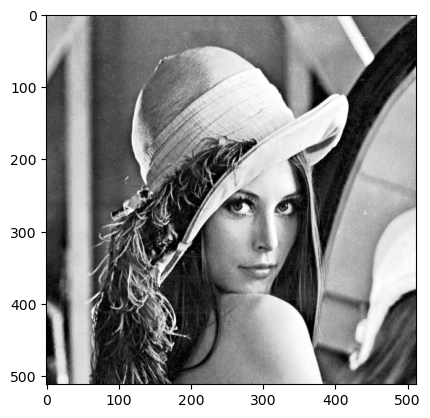

In [3]:
# Normalize
histogram = histogram / (h * w)
CDF = histogram.cumsum()

equalized_img = CDF[img.flatten()]
equalized_img = equalized_img.reshape(img.shape)

plt.imshow(equalized_img, cmap="gray")

Back Projection

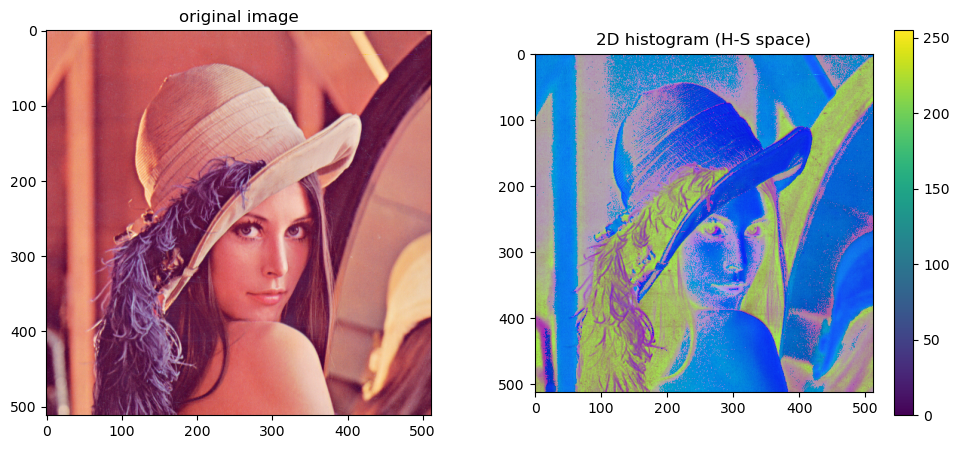

In [6]:
def quantize(value: int, q: int):
    return int(value * q / 256)

def compute_2d_histogram(H, S, q=64):
    M, N = H.shape
    hist = np.zeros((q, q), dtype=np.float32)

    # calculate histogram
    for i in range(M):
        for j in range(N):
            h_idx = quantize(H[i,j], q)
            s_idx = quantize(S[i,j], q)
            hist[h_idx, s_idx] += 1
    
    # normalize histogram
    hist /= (M * N)

    return hist

def histogram_ratio(hist_model, hist_input):
    ratio_hist = np.minimum(hist_model /  (hist_input + 1e-6), 1.0)
    return ratio_hist

def histogra_backprojection(H, S, ratio_hist, q=64):
    M, N = H.shape
    backprojection = np.zeros((M, N), dtype=np.float32)

    for i in range(M):
        for j in range(N):
            h_idx = quantize(H[i, j], q)
            s_idx = quantize(S[i, j], q)
            backprojection[i, j] = ratio_hist[h_idx, s_idx]
        
    return backprojection

image_path = "./image/lena.bmp"
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

H, S, _ = cv2.split(hsv_img)

q = 64 # level of quantization
histogram = compute_2d_histogram(H, S, q)

plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("original image")

plt.subplot(1,2,2)
plt.imshow(hsv_img)
plt.title("2D histogram (H-S space)")
plt.colorbar()
plt.show()

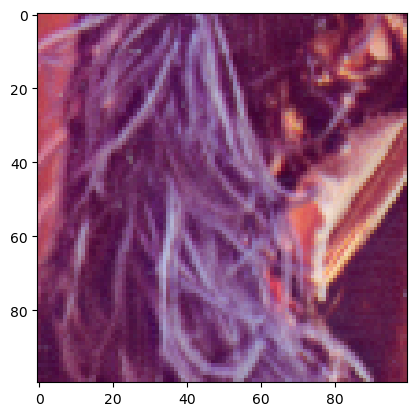

In [ ]:
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
H, S, _ = cv2.split(hsv_img)

model_img = img[300:400, 80:180]
model_hsv = cv2.cvtColor(model_img, cv2.COLOR_RGB2HSV)
H_model, S_model, _ = cv2.split(model_hsv)

q = 64
hist_model = compute_2d_histogram(H_model, S_model, q)
hist_input = compute_2d_histogram(H, S, q)

ratio_hist = histogram_ratio(hist_model, hist_input)

backprojection = histogra_backprojection(H, S, ratio_hist, q)

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("original")

plt.subplot(1, 3, 2)
plt.imshow(hist_input, cmap="jet", origin="lower")
plt.title("2D Histogram (H-S space)")

plt.subplot(1, 3, 3)
plt.imshow(backprojection, cmap="gray")
plt.title("Histogram Backprojeciton Confidence Map")

plt.show()